In [1]:
import os
import numpy as np
import torch
from torch.autograd import Variable
from torchvision.models.vgg import model_urls
from models.models import Custom_AlexNet, Custom_ResNet34, Custom_VGG16

# All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn as nn 
import torch.nn.functional as F

# For all Optimization algorithms, SGD, Adam, etc.
import torch.optim as optim

# Loading and Performing transformations on dataset
import torchvision
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler

#Labels in CSV and Inputs in Fits in a folder
import pandas as pd
import sunpy.map
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

#For Confusion Matrix
from sklearn.metrics import confusion_matrix

#Warnings
import warnings
warnings.simplefilter("ignore", Warning)

#Time Computation
import timeit

In [2]:
class MyJP2Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv1 = pd.read_csv(csv_file, iterator=True)
        iter_csv2 = pd.read_csv(csv_file, iterator=True)
        df1 = pd.concat([chunk[chunk['goes_class'] == 0] for chunk in iter_csv1])
        df2 = pd.concat([chunk[chunk['goes_class'] == 2] for chunk in iter_csv2])
        df  = pd.concat([df1, df2])
        df.loc[df['goes_class'] == 2, 'goes_class'] = 1
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)

        if self.transform:
            image = self.transform(hmi)
            
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    
class RotateAugmentation(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv = pd.read_csv(csv_file, iterator=True)
        df = pd.concat([chunk[chunk['goes_class'] == 2] for chunk in iter_csv])
        df.loc[df['goes_class'] == 2, 'goes_class'] = 1
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)
    
class FlipAugmentation(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        iter_csv = pd.read_csv(csv_file, iterator=True)
        df = pd.concat([chunk[chunk['goes_class'] == 2] for chunk in iter_csv])
        df.loc[df['goes_class'] == 2, 'goes_class'] = 1
        self.annotations = df
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))
        #print(y_label)

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label)

    def __len__(self):
        return len(self.annotations)

In [3]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:1' if use_cuda else 'cpu')
torch.backends.cudnn.benchmark = True
print(device)

cuda:1


In [4]:
torch.cuda.current_device()

0

In [5]:
# Load Data
transformations = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.Resize(512),
    transforms.ToTensor()
])


rotation = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.RandomRotation(degrees=(-5,5)),
    transforms.Resize(512),
    transforms.ToTensor()
])


flip = transforms.Compose([
    transforms.CenterCrop(3300),
    transforms.RandomChoice([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomVerticalFlip(p=1.0)]),
    transforms.Resize(512),
    transforms.ToTensor()
])

#Train Time-Based Split -- Data from 2010-2014 in Train Set
original_train = MyJP2Dataset(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = transformations)
rotation_set = RotateAugmentation(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = rotation)

flip_set = FlipAugmentation(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_train.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = flip)

train_set = ConcatDataset([flip_set, original_train, rotation_set])
print(2*len(rotation_set), len(original_train), len(train_set))
#Data From 2015-2018 are randomly splitted into 40% and 60% into validation and test set resp.
val_set = MyJP2Dataset(csv_file = '/data/hmi_BI_daily/simbig_labels/multi-class/Multi_Fold4_val.csv', 
                             root_dir = '/data/hmi_BI_daily/hmipng/',
                             transform = transformations)

1132 3695 4827


In [6]:
def imbalance_weights(dataset):
    target = []
    with torch.no_grad():
        for i in range(len(dataset)):
            target.append(np.asarray(dataset[i][1]))
            if i%500 == 0:
                print(f'{(i*100)/len(dataset):.2f}% Complete')
        targets = np.asarray(target)
        csc = np.array([len(np.where(targets == t)[0]) for t in np.unique(targets)])
        print(csc)
        majority_weight = 1/csc[0]
        minority_weight = 1/csc[1]
        sample_weights = np.array([majority_weight, minority_weight])
        samples_weight = sample_weights[targets]
        samples_weight = torch.from_numpy(samples_weight)
        return samples_weight

train_samples_weight = imbalance_weights(train_set)
#test_samples_weight = imbalance_weights(test_set)
#val_samples_weight = imbalance_weights(val_set)

0.00% Complete
10.36% Complete
20.72% Complete
31.08% Complete
41.43% Complete
51.79% Complete
62.15% Complete
72.51% Complete
82.87% Complete
93.23% Complete
[3129 1698]


In [7]:
batch_size = 24
sampler1   = WeightedRandomSampler(weights=train_samples_weight, num_samples= len(train_samples_weight), replacement=True)
#sampler2  = WeightedRandomSampler(weights=test_samples_weight, num_samples= len(test_samples_weight), replacement=True)
#sampler3  = WeightedRandomSampler(weights=val_samples_weight, num_samples= int(200), replacement=False)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, sampler=sampler1,  num_workers=4, shuffle = False)

val_loader = DataLoader(dataset=val_set, batch_size=batch_size, num_workers=4, shuffle=False)

#test_loader = DataLoader(dataset=test_set, batch_size=batch_size, num_workers=4, shuffle=False)

for i, (data, target) in enumerate(train_loader):
    print("batch index {}, 0/2: {}/{}".format(
        i,
        len(np.where(target.numpy() == 0)[0]),
        len(np.where(target.numpy() == 1)[0])))
    if i==3:
        break

batch index 0, 0/2: 11/13
batch index 1, 0/2: 6/18
batch index 2, 0/2: 13/11
batch index 3, 0/2: 14/10


In [8]:
def visualize(data_loader):
    cmap = plt.get_cmap('hmimag')
    dataiter = iter(data_loader)
    #dataiter.next()
    images, labels = dataiter.next()
    flare_types = {0: 'Non_flare', 1: 'Flare'}
    fig, axis = plt.subplots(5, 5, figsize=(15, 15))
    for i, ax in enumerate(axis.flat):
        with torch.no_grad():
            image, label = images[i], labels[i]
            ax.imshow(image.permute(1,2,0), cmap=cmap, vmin=0, vmax=1) # add image
            ax.set(title = f"{flare_types[label.item()]}")

#visualize(train_loader)

In [9]:
# Hyperparameters

in_channel = 1
learning_rate = 0.01
num_epochs = 80


model = Custom_VGG16(ipt_size=(512, 512), pretrained=True).to(device)

# Loss and optimizer

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [10]:
def accuracy_score(prediction, target):
    TN, FP, FN, TP = confusion_matrix(target, prediction).ravel()
    print("TP: ", TP, "FP: ", FP, "TN: ", TN, "FN: ", FN)
    #TSS Computation also known as "recall"
    tp_rate = TP / float(TP + FN) if TP > 0 else 0  
    fp_rate = FP / float(FP + TN) if FP > 0 else 0
    TSS = tp_rate - fp_rate
    
    #HSS2 Computation
    N = TN + FP
    P = TP + FN
    HSS = (2 * (TP * TN - FN * FP)) / float((P * (FN + TN) + (TP + FP) * N))

    return TSS, HSS

In [11]:
def sklearn_Compatible_preds_and_targets(model_prediction_list, model_target_list):
    y_pred_list = []
    preds = []
    target_list = []
    tgts = []
    y_pred_list = [a.squeeze().tolist() for a in model_prediction_list]
    preds = [item for sublist in y_pred_list for item in sublist]
    target_list = [a.squeeze().tolist() for a in model_target_list]
    tgts = [item for sublist in target_list for item in sublist]
    return accuracy_score(preds, tgts)

In [12]:
# Training Network
print("Training in Progress..")
train_loss_values = []
val_loss_values = []
train_tss_values = []
val_tss_values = []
train_hss_values = []
val_hss_values = []
train_time = []
val_time = []
learning_rate_values = []
for epoch in range(num_epochs):
    
    #Timer for Training one epoch
    start_train = timeit.default_timer() 
    
    # setting the model to train mode
    model.train()
    train_loss = 0
    train_tss = 0.
    train_hss = 0.
    train_prediction_list = []
    train_target_list = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)
        train_target_list.append(targets)
        
        # forward prop
        scores = model(data)
        loss = criterion(scores, targets)
        _, predictions = torch.max(scores,1)
        train_prediction_list.append(predictions)
        
        # backward prop
        optimizer.zero_grad()
        loss.backward()
        
        # Adam step
        optimizer.step()
        
        # accumulate the training loss
        #print(loss.item())
        train_loss += loss.item()
        #train_acc+= acc.item()
        
    stop_train = timeit.default_timer()
    train_time.append(stop_train-start_train)
    # Validation: setting the model to eval mode
    model.eval()
    start_val = timeit.default_timer()
    val_loss = 0.
    val_tss = 0.
    val_hss = 0.
    val_prediction_list = []
    val_target_list = []
    # Turning off gradients for validation
    with torch.no_grad():
        for d, t in val_loader:
            # Get data to cuda if possible
            d = d.to(device=device)
            t = t.to(device=device)
            val_target_list.append(t)
            
            # forward pass
            s = model(d)
            #print("scores", s)
                                   
            # validation batch loss and accuracy
            l = criterion(s, t)
            _, p = torch.max(s,1)
            #print("------------------------------------------------")
            #print(torch.max(s,1))
            #print('final', p)
            val_prediction_list.append(p)
            
            # accumulating the val_loss and accuracy
            val_loss += l.item()
            #val_acc += acc.item()
            del d,t,s,l,p
    scheduler.step(val_loss)
    stop_val = timeit.default_timer()
    val_time.append(stop_val-start_val)
    learning_rate_values.append(optimizer.param_groups[0]['lr'])
    #Epoch Results
    train_loss /= len(train_loader)
    train_loss_values.append(train_loss)
    val_loss /= len(val_loader)
    val_loss_values.append(val_loss)
    train_tss, train_hss = sklearn_Compatible_preds_and_targets(train_prediction_list, train_target_list)
    train_tss_values.append(train_tss)
    train_hss_values.append(train_hss)
    val_tss, val_hss = sklearn_Compatible_preds_and_targets(val_prediction_list, val_target_list)
    val_tss_values.append(val_tss)
    val_hss_values.append(val_hss)
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print(f'Training--> loss: {train_loss:.4f}, TSS: {train_tss:.4f}, HSS2: {train_hss:.4f} | Val--> loss: {val_loss:.4f}, TSS: {val_tss:.4f} | HSS2: {val_hss:.4f} ')

Training in Progress..
TP:  1042 FP:  1033 TN:  1410 FN:  1342
TP:  243 FP:  1003 TN:  0 FN:  0
Epoch: 1/80
Training--> loss: 0.6936, TSS: 0.0142, HSS2: 0.0143 | Val--> loss: 0.7289, TSS: 0.0000 | HSS2: 0.0000 
TP:  1618 FP:  996 TN:  1373 FN:  840
TP:  226 FP:  364 TN:  639 FN:  17
Epoch: 2/80
Training--> loss: 0.6482, TSS: 0.2378, HSS2: 0.2381 | Val--> loss: 0.6368, TSS: 0.5671 | HSS2: 0.3680 
TP:  1549 FP:  611 TN:  1845 FN:  822
TP:  49 FP:  18 TN:  985 FN:  194
Epoch: 3/80
Training--> loss: 0.5820, TSS: 0.4045, HSS2: 0.4052 | Val--> loss: 0.3528, TSS: 0.1837 | HSS2: 0.2532 
TP:  1849 FP:  597 TN:  1823 FN:  558
TP:  148 FP:  75 TN:  928 FN:  95
Epoch: 4/80
Training--> loss: 0.5051, TSS: 0.5215, HSS2: 0.5215 | Val--> loss: 0.3194, TSS: 0.5343 | HSS2: 0.5515 
TP:  1840 FP:  500 TN:  1974 FN:  513
TP:  147 FP:  95 TN:  908 FN:  96
Epoch: 5/80
Training--> loss: 0.4563, TSS: 0.5799, HSS2: 0.5800 | Val--> loss: 0.3365, TSS: 0.5102 | HSS2: 0.5110 
TP:  1983 FP:  510 TN:  1844 FN:  490
TP

TP:  2094 FP:  344 TN:  2079 FN:  310
TP:  195 FP:  204 TN:  799 FN:  48
Epoch: 43/80
Training--> loss: 0.3117, TSS: 0.7291, HSS2: 0.7290 | Val--> loss: 0.3912, TSS: 0.5991 | HSS2: 0.4819 
TP:  2099 FP:  383 TN:  2058 FN:  287
TP:  195 FP:  204 TN:  799 FN:  48
Epoch: 44/80
Training--> loss: 0.3177, TSS: 0.7228, HSS2: 0.7225 | Val--> loss: 0.3912, TSS: 0.5991 | HSS2: 0.4819 
TP:  2110 FP:  338 TN:  2079 FN:  300
TP:  195 FP:  204 TN:  799 FN:  48
Epoch: 45/80
Training--> loss: 0.3100, TSS: 0.7357, HSS2: 0.7357 | Val--> loss: 0.3912, TSS: 0.5991 | HSS2: 0.4819 
TP:  2073 FP:  367 TN:  2054 FN:  333
TP:  195 FP:  204 TN:  799 FN:  48
Epoch: 46/80
Training--> loss: 0.3243, TSS: 0.7100, HSS2: 0.7100 | Val--> loss: 0.3912, TSS: 0.5991 | HSS2: 0.4819 
TP:  2065 FP:  371 TN:  2082 FN:  309
TP:  195 FP:  204 TN:  799 FN:  48
Epoch: 47/80
Training--> loss: 0.3216, TSS: 0.7186, HSS2: 0.7183 | Val--> loss: 0.3912, TSS: 0.5991 | HSS2: 0.4819 
TP:  2146 FP:  313 TN:  2071 FN:  297
TP:  195 FP:  204

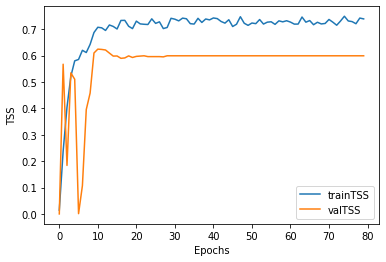

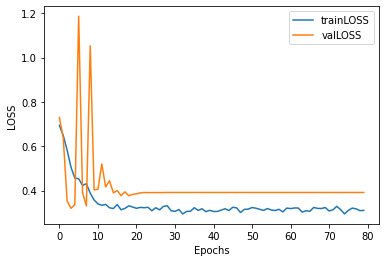

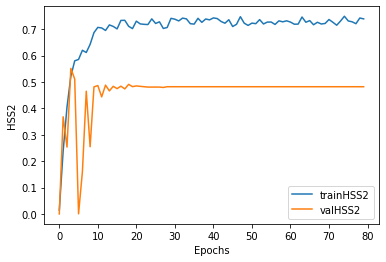

In [13]:
def plot_results(train_values, val_values, plt_type):
    plt.plot(train_values, label='train'+str(plt_type))
    plt.plot(val_values, label='val'+str(plt_type))
    plt.xlabel('Epochs')
    plt.ylabel(plt_type)
    plt.legend()
    plt.show()
    
plot_results(train_tss_values, val_tss_values, 'TSS') 
plot_results(train_loss_values, val_loss_values, 'LOSS')
plot_results(train_hss_values, val_hss_values, 'HSS2')

In [14]:
PATH = 'trained-models/vgg16-buffer-binary-fold4.pth'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
            }, PATH)

results = {
    'train_tss_values':train_tss_values,
    'val_tss_values':val_tss_values,
    'train_hss_values':train_hss_values,
    'val_hss_values':val_hss_values,
    'train_loss_values':train_loss_values,
    'val_loss_values':val_loss_values,
    'learning_rate': learning_rate_values,
    'train_time': train_time,
    'val_time': val_time
}
df = pd.DataFrame(results, columns=['train_tss_values','val_tss_values', 'train_hss_values', 'val_hss_values', 'train_loss_values', 'val_loss_values', 'learning_rate', 'train_time', 'val_time' ])
df.to_csv(r'results/vgg16-buffer-binary-fold4.csv', index=False, header=True)